In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib notebook

import imars3d
import tomopy
import timeit

from imars3d.ui.widgets import Tqdm
import panel as pn

from imars3d.backend.dataio.data import load_data, _get_filelist_by_dir
from imars3d.backend.morph.crop import detect_bounds
from imars3d.backend.diagnostics import tilt
from imars3d.backend.diagnostics.rotation import find_rotation_center
from imars3d.backend.corrections.ring_removal import remove_ring_artifact
from imars3d.backend.reconstruction import recon
from imars3d.backend.dataio.data import save_data

from __code.imars3dui import Imars3dui
from __code.roi_selection_ui import Interface

# import bm3d

from __code import system
system.System.select_working_dir()
from __code.__all import custom_style
custom_style.style()

** Using Debugging Mode! **


In [2]:
%gui qt

# Select input data 

## raw data

In [3]:
# o_imars3dui = Imars3dui(working_dir=system.System.get_working_dir())
o_imars3dui = Imars3dui(working_dir="/Users/j35/HFIR/CG1D/IPTS-31148")
# o_imars3dui.select_raw()

## ob 

In [4]:
# o_imars3dui.select_ob()

## dc 

In [5]:
# o_imars3dui.select_dc()

In [6]:
# for debugging only

o_imars3dui.input_data_folders = {'raw': ['/Users/j35/HFIR/CG1D/IPTS-31148/ct_scans/December3_2022'],
                                  'ob': ['/Users/j35/HFIR/CG1D/IPTS-31148/ob/December2_2022', '/Users/j35/HFIR/CG1D/IPTS-31148/ob/December3_2022'],
                                  'dc': ['/Users/j35/HFIR/CG1D/IPTS-31148/dc/2022_12_05']}

o_imars3dui.saving_list_of_files()

# Load data 

ct:   0%|          | 0/1288 [00:00<?, ?it/s]

ob:   0%|          | 0/20 [00:00<?, ?it/s]

dc:   0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


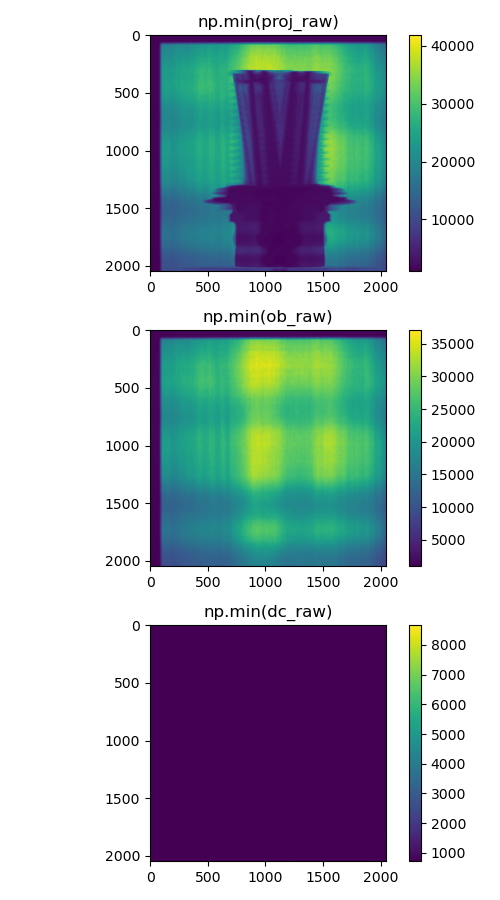

In [7]:
o_imars3dui.load_and_display_data()

# Crop 

In [8]:
o_gui = Interface(o_imars3dui=o_imars3dui,
                  mode='crop',
                  callback=o_imars3dui.crop_and_display_data)
o_gui.show()

Running Gamma filtering ...


# gamma filtering  (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [9]:
o_imars3dui.gamma_filtering()

Running gamma filtering ...
Gamma filtering done in 89.07s


# normalization (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

Running normalization ...
normalization done in 45.06s


<IPython.core.display.Javascript object>


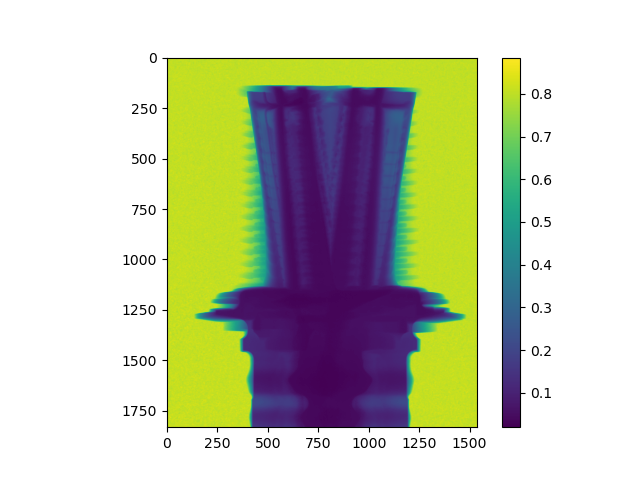

In [10]:
o_imars3dui.normalization_and_display()

# beam fluctuation correction

Select a region that does not contain the sample to improve the normalization

<IPython.core.display.Javascript object>


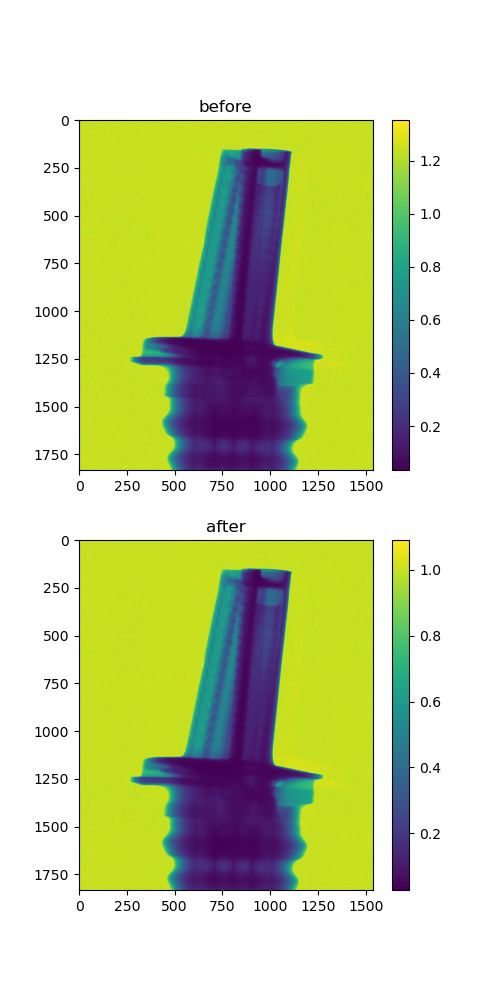

In [11]:
o_gui = Interface(o_imars3dui=o_imars3dui,
                  mode='background',
                  callback=o_imars3dui.beam_fluctuation_correction)
o_gui.show()

# attenuation to transmission

<IPython.core.display.Javascript object>


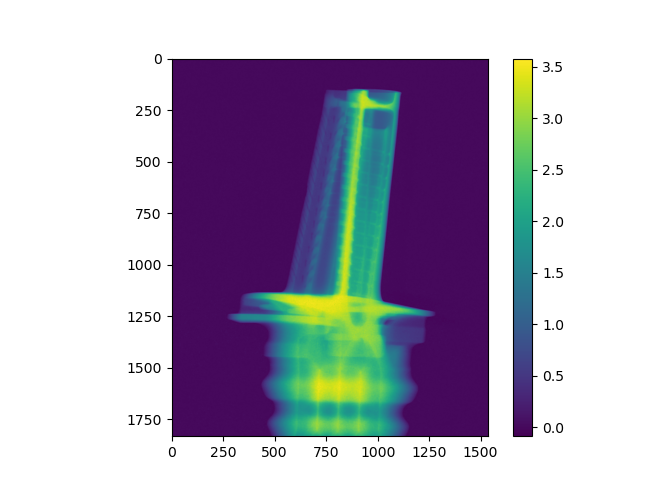

In [12]:
o_imars3dui.minus_log_and_display()

# Tilt correction (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [13]:
o_imars3dui.tilt_correction_and_display()

Looking at 180 degrees pairs indexes!
Calculating tilt ...


TypeError: unsupported format string passed to OptimizeResult.__format__

# Rotation center (<font size=5 type="bold">Z</font><font size=4 type="bold">Z</font><font size=3 type="bold">Z</font>)

In [ ]:
o_imars3dui.rotation_center()

In [ ]:
# t0 = timeit.default_timer()

# pn.extension()
# tqdm = Tqdm()
# display(tqdm)

# rot_center = find_rotation_center(arrays=proj_tilt_corrected,
#                                  angles=rot_angles,
#                                  in_degrees=True,
#                                  atol_deg=a,
#                                  tqdm_class=tqdm
#                                  )
# t1 = timeit.default_timer()
# print(f"time: {t1-t0} s")

In [ ]:
print(f"{rot_center=}")

# Strikes removal

### using imars3d - ketcham method working on 3D stack

In [ ]:
t0 = timeit.default_timer()

pn.extension()
tqdm = Tqdm()
display(tqdm)

proj_strikes_removed = remove_ring_artifact(arrays=proj_tilt_corrected,
                                           kernel_size=5,
                                           max_workers=ncore,
                                           tqdm_class=tqdm)


t1 = timeit.default_timer()
print(f"time= {t1-t0} s")

In [ ]:
# fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
#                                num="imars3d ketcham ",
#                                figsize=(5,10))

# # before beam fluctuation
# #proj_norm_min = np.min(proj_norm, axis=0)
# #fig0 = ax0.imshow(proj_norm_min)
# fig0 = ax0.imshow(proj_tilt_corrected[0])
# ax0.set_title("before")
# plt.colorbar(fig0, ax=ax0)

# # after beam fluctuation
# # proj_norm_beam_fluctuation_min = np.min(proj_norm_beam_fluctuation, axis=0)
# # fig1 = ax1.imshow(proj_norm_beam_fluctuation_min)
# fig1 = ax1.imshow(proj_strikes_removed[0])
# ax1.set_title("after")
# plt.colorbar(fig1, ax=ax1)

### using tomopy (Vo)

In [ ]:
# nchunk = int(proj_tilt_corrected.shape[0]/ncore) + 1
# print(f"chunk size: {nchunk}")

# t0 = timeit.default_timer()
# proj_strikes_removed = tomopy.remove_all_stripe(proj_tilt_corrected,
#                                                ncore=ncore,
#                                                nchunk=nchunk)

# t1 = timeit.default_timer()
# print(f"time= {t1-t0:.2f} s")

In [ ]:
# fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
#                                num="tomopy Vo ",
#                                figsize=(5,10))

# # before beam fluctuation
# #proj_norm_min = np.min(proj_norm, axis=0)
# #fig0 = ax0.imshow(proj_norm_min)
# fig0 = ax0.imshow(proj_tilt_corrected[0])
# ax0.set_title("before")
# plt.colorbar(fig0, ax=ax0)

# # after beam fluctuation
# # proj_norm_beam_fluctuation_min = np.min(proj_norm_beam_fluctuation, axis=0)
# # fig1 = ax1.imshow(proj_norm_beam_fluctuation_min)
# fig1 = ax1.imshow(proj_strikes_removed[0])
# ax1.set_title("after")
# plt.colorbar(fig1, ax=ax1)

### bm3d

In [ ]:
# import bm3d_streak_removal as bm3d

In [ ]:
# t0 = timeit.default_timer()
# proj_mlog = 




# t1 = timeit.default_timer()
# print(f"time: {t1-t0: .2f} s")

# Reconstruction 

In [ ]:
t0 = timeit.default_timer()

# converting angles from deg to radians
rot_ang_rad = np.radians(rot_angles)

reconstruction = recon(arrays=proj_strikes_removed,
             center=rot_center[0],
             theta=rot_ang_rad,
             )

t1 = timeit.default_timer()
print(f"time: {t1-t0:.2f} s")

In [ ]:
plt.figure()
plt.imshow(reconstruction[1000], vmin=0, vmax=0.004)
plt.colorbar()


# Export


In [ ]:
output_folder = "/HFIR/CG1D/IPTS-31148/shared/processed_data"
save_data(data=np.asarray(reconstruction),
         outputbase=output_folder,
         name="small_turbine")
